In [19]:
import pandas as pd

# import dataset
file_path = 'data/Contucci_Marco.csv'
data = pd.read_csv(file_path)

# Visualizzazione delle prime righe del dataset per capire la sua struttura
data.head()

,obs,oil,inf,growth,pa,e,pb
0,1973M01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1973M02,-0.910593,-0.651378,-0.808943,0.192845,-2.800062,-1.251061
2,1973M03,-1.037341,-0.464413,0.419297,-0.790535,-2.969075,-2.473440
3,1973M04,0.238282,-0.557528,0.396233,-1.929574,-6.481253,-5.062312
4,1973M05,-0.715433,-0.972816,0.184617,-6.806141,-12.416007,-10.776334


# 1 PLOT

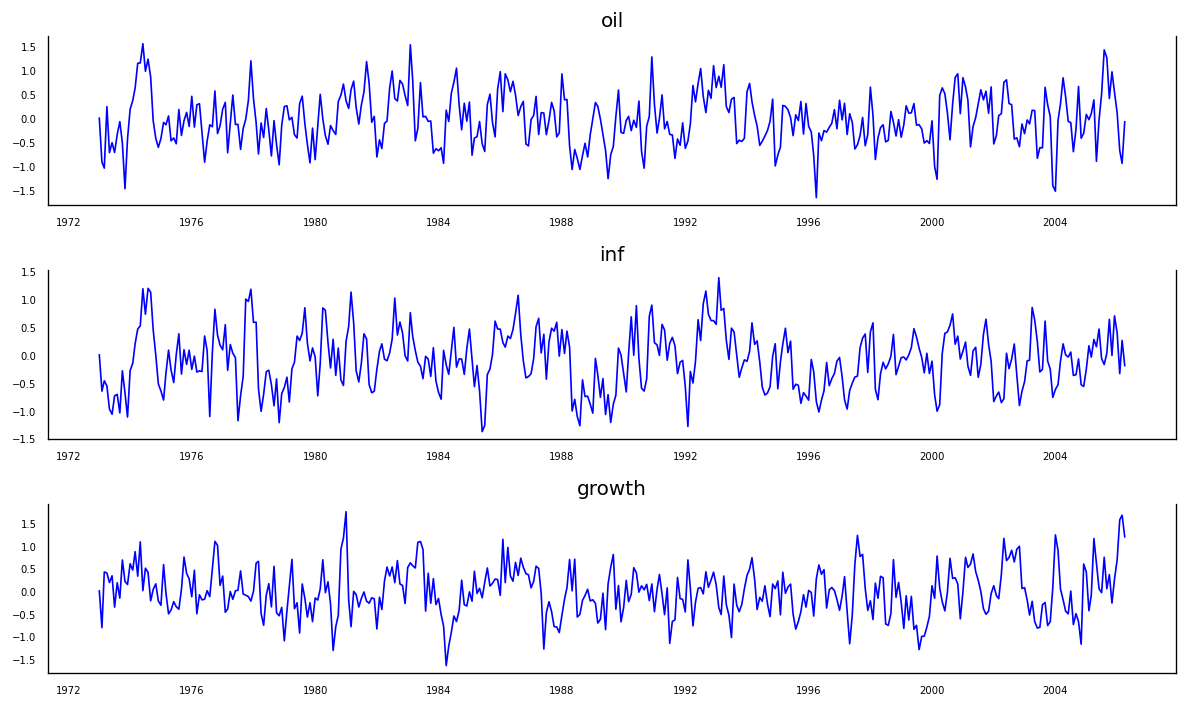

In [20]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

# Selection of the variables for the VAR model
var_data = data[["oil", "inf", "growth"]]
# Convert time format
var_data.index = pd.to_datetime(data['obs'], format='%YM%m')
# Control if there are missing values
missing_values = var_data.isnull().sum()
# No Missing Values :)

fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = var_data.iloc[:, i]
    ax.plot(data, color='blue', linewidth=1)
    # Better Visualization
    ax.set_title(var_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)
plt.tight_layout()

# 2 STATIONARITY

In [21]:
# Check for Stationary
import statsmodels.tsa.stattools as ts

# Test Augmented Dickey-Fuller(ADF) for Stationary
adf_results = {}
for col in var_data.columns:
    result = ts.adfuller(var_data[col], autolag='AIC')
    adf_results[col] = result[1]  # p-value
print("ADF p-values:", adf_results)

ADF p-values: {'oil': 5.0605659286589936e-20, 'inf': 4.380880443740695e-16, 'growth': 1.2696397021236439e-20}


# 3 OPTIMAL ORDER VAR

In [22]:
# Determining optimal order for the VAR
model = VAR(var_data)
order_selection = model.select_order(maxlags = 15)
selected_order = order_selection.selected_orders
# Print the selected order
print(selected_order)

# Fit the model VAR(1) and take the residuals
var_model = model.fit(1)
residuals = var_model.resid

# Tests on the separated residuals vector
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch, normal_ad
residual_tests = {}

for col in var_data.columns:
    res = residuals[col]
    # Ljung-Box test
    lb_pvalue = acorr_ljungbox(res, lags=[10], return_df=True)['lb_pvalue'].iloc[0]
    # ARCH test
    arch_stat, arch_pvalue, _, _ = het_arch(res)
    # Normality test (Anderson-Darling)
    ad_stat, ad_pvalue = normal_ad(res)
    # Update the results 
    residual_tests[col] = {
        "Ljung-Box Test p-value": lb_pvalue,
        "ARCH Test Statistic": arch_stat,
        "ARCH Test p-value": arch_pvalue,
        "Normality Test (Anderson-Darling) Statistic": ad_stat,
        "Normality Test (Anderson-Darling) p-value": ad_pvalue
    }
print(residual_tests)

{'aic': 1, 'bic': 1, 'hqic': 1, 'fpe': 1}
{'oil': {'Ljung-Box Test p-value': 0.5584240309965823, 'ARCH Test Statistic': 13.370343477836585, 'ARCH Test p-value': 0.2036961260650098, 'Normality Test (Anderson-Darling) Statistic': 0.20841457046390133, 'Normality Test (Anderson-Darling) p-value': 0.8640099864656976}, 'inf': {'Ljung-Box Test p-value': 0.9091054866401567, 'ARCH Test Statistic': 13.696783632676427, 'ARCH Test p-value': 0.18727686903744709, 'Normality Test (Anderson-Darling) Statistic': 0.2977466602193317, 'Normality Test (Anderson-Darling) p-value': 0.5874242609486036}, 'growth': {'Ljung-Box Test p-value': 0.7172479757459973, 'ARCH Test Statistic': 8.071620823256053, 'ARCH Test p-value': 0.6218411412650133, 'Normality Test (Anderson-Darling) Statistic': 0.3552227247063229, 'Normality Test (Anderson-Darling) p-value': 0.45841993067751463}}


C:\Users\contu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


# 4 IRF

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 04, Jan, 2024
Time:                     12:58:18
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -4.95241
Nobs:                     399.000    HQIC:                  -5.02487
Log likelihood:          -674.529    FPE:                 0.00626749
AIC:                     -5.07238    Det(Omega_mle):      0.00608271
--------------------------------------------------------------------
Results for equation oil
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            -0.004659         0.023365           -0.199           0.842
L1.oil            0.486214         0.049620            9.799           0.000
L1.inf            0.074181         0.051280            1.447           0.148
L

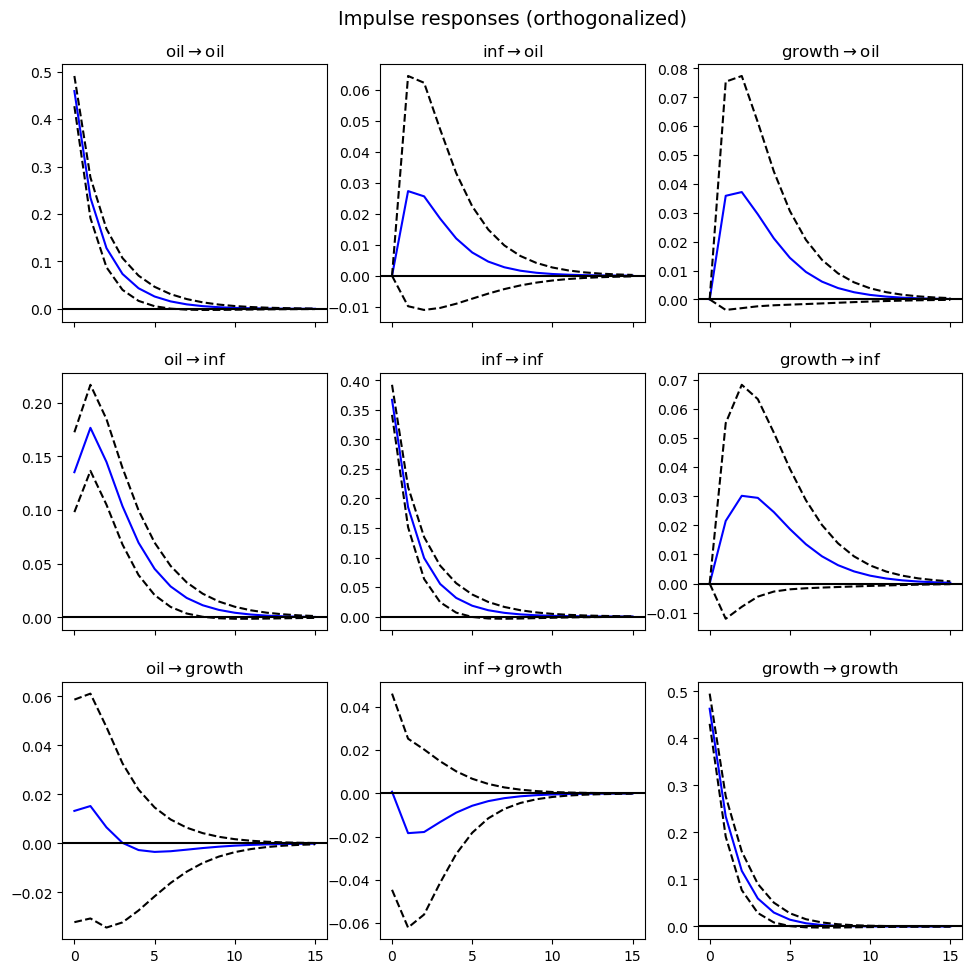

In [23]:
# Summary of the model VAR(1)
print(var_model.summary())

# calculating structural impulse response functions
irf = var_model.irf(15)  # Calcolando le risposte per 15 periodi

# Plot the structural impulse response functions
irf.plot(orth = True)
plt.show()

# 5 ARMA MODEL 

ARCH Test Statistic: 29.43105213476845
p-value: 0.001060700150798829


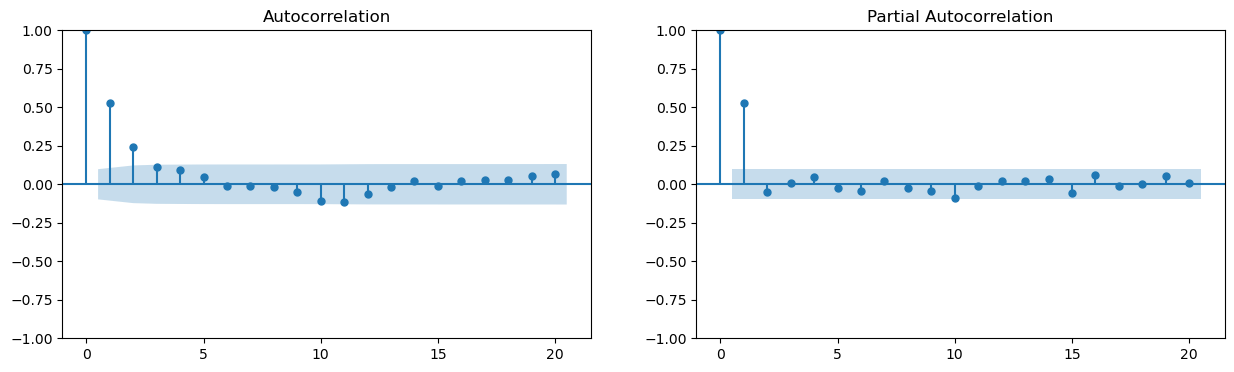

C:\Users\contu\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\contu\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\contu\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\contu\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\contu\anaconda3\Lib\site-packages\statsmodels\base\model

{'aic':             0           1           2           3           4
0  648.263774  540.736475  521.600802  522.755645  523.844082
1  519.021287  519.908598  521.877342  523.098110  524.643899
2  519.914060  521.902617  523.603611  524.903501  517.451246
3  521.879641  523.836896  524.182290  525.076956  526.325354
4  522.819171  524.710992  524.550165  526.994423  528.376228, 'bic':             0           1           2           3           4
0  656.246703  552.710869  537.566660  542.712968  547.792870
1  530.995681  535.874456  541.834665  547.046897  552.584150
2  535.879919  541.859940  547.552398  552.843753  549.382962
3  541.836964  547.785684  552.122542  557.008672  562.248535
4  546.767958  552.651243  556.481881  562.917604  568.290873, 'aic_min_order': (2, 4), 'bic_min_order': (1, 0)}


C:\Users\contu\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [13]:
# ARMA of oil
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import arma_order_select_ic
import matplotlib.pyplot as plt
oil_series = data['oil']

# Check for Homoskedasticity
arch_testo = het_arch(oil_series)
print("ARCH Test Statistic:", arch_testo[0])
print("p-value:", arch_testo[1])

# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
plot_acf(oil_series, lags = 20, ax = axes[0])
plot_pacf(oil_series, lags = 20, ax = axes[1])
plt.show()

# Optimal order based on information criterion
optimal_order = arma_order_select_ic(oil_series, ic=['aic', 'bic'], max_ar=4, max_ma=4)
print(optimal_order)

# AR(1) FITTING

In [30]:
from statsmodels.tsa.arima.model import ARIMA

# Estimating ARMA(1,0) = ARIMA(1,0,0)
arma_model = ARIMA(oil_series, order = (1, 0, 0), trend = 'n')
arma_result = arma_model.fit()

# Summary of the model
print(arma_result.summary())

                               SARIMAX Results                                
Dep. Variable:                    oil   No. Observations:                  400
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -256.638
Date:                Thu, 04 Jan 2024   AIC                            517.276
Time:                        14:01:55   BIC                            525.259
Sample:                             0   HQIC                           520.438
                                - 400                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5291      0.042     12.506      0.000       0.446       0.612
sigma2         0.2111      0.015     14.201      0.000       0.182       0.240
Ljung-Box (L1) (Q):                   0.32   Jarque-

# F-TEST

In [45]:
from scipy import stats
import numpy as np
# F-test
rss_full = np.sum(arma_result.resid**2)

# Fitting a null model (mean only, no AR or MA components)
null_model = ARIMA(oil_series, order=(0, 0, 0)).fit()
rss_null = np.sum(null_model.resid**2)

# Number of observations and number of predictors
n = len(oil_series)
p = 1  # Only one predictor, the AR(1) term

# Calculating the F-statistic
f_stat = ((rss_null - rss_full) / p) / (rss_full / (n - p - 1))
f_p_value = 1 - stats.f.cdf(f_stat, p, n - p - 1)

print("F-test: ",f_stat,"\np_value: ", f_p_value)

F-test:  154.65909965180455 
p_value:  1.1102230246251565e-16
